# **Nama  : Maulana Agus Setiawan**
# **NIM   : 2209106024**

LINK DATASET  : [Face Mask Detection](https://www.kaggle.com/datasets/ashishjangra27/face-mask-12k-images-dataset)

# **Import Library**

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.utils import to_categorical

# **Ekstraksi Fitur dengan HOG (Histogram of Oriented Gradients)**
#### `HOG` sangat cocok untuk deteksi pola visual seperti wajah, masker, dsb. Ia menghitung arah gradien dan intensitas tepi dari gambar. Gambar diubah ke `grayscale` lalu diekstrak fiturnya.Ukuran gambar dinormalisasi ke `128x128 px` untuk konsistensi.

In [ ]:
def extract_hog_features(image):
    image = cv2.resize(image, (128, 128))
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    features, _ = hog(gray, pixels_per_cell=(8, 8), cells_per_block=(2, 2),
                      visualize=True, block_norm='L2-Hys')
    return features

# **Load Dataset dan Label**
#### Dataset dibaca dari struktur folder, di mana setiap kelas memiliki folder sendiri. Setiap gambar diproses untuk diambil fitur HOG-nya, lalu disimpan bersama labelnya.

In [ ]:
def load_dataset(folder_path):
    features = []
    labels = []
    for label_name in os.listdir(folder_path):
        label_folder = os.path.join(folder_path, label_name)
        if not os.path.isdir(label_folder): continue
        for img_name in os.listdir(label_folder):
            img_path = os.path.join(label_folder, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                feat = extract_hog_features(img)
                features.append(feat)
                labels.append(label_name)
    return np.array(features), np.array(labels)

In [ ]:
train_img_path = '/content/drive/MyDrive/Tugas semester 6/Computer Vision/Face Mask Dataset/Train'
val_img_path = '/content/drive/MyDrive/Tugas semester 6/Computer Vision/Face Mask Dataset/Validation'
test_img_path = '/content/drive/MyDrive/Tugas semester 6/Computer Vision/Face Mask Dataset/Test'

X_train, y_train = load_dataset(train_img_path)
X_val, y_val = load_dataset(val_img_path)
X_test, y_test = load_dataset(test_img_path)

#  **Encode Label dan One-Hot Encoding**
#### Label dikodekan ke bentuk numerik karena model membutuhkan input numerik dan One-hot encoding dilakukan karena y_train_enc dibutuhkan dalam bentuk kategori.

# **Standardisasi Fitur**
#### SVM sangat sensitif terhadap skala fitur. StandardScaler membuat distribusi setiap fitur memiliki mean = 0 dan std = 1. Ini membuat proses training lebih stabil dan cepat konvergen.

In [ ]:
le = LabelEncoder()
y_train_enc = to_categorical(le.fit_transform(y_train))
y_val_enc = to_categorical(le.transform(y_val))
y_test_enc = to_categorical(le.transform(y_test))

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# **Pelatihan Model SVM**
#### Menggunakan Support Vector Classifier (`SVC`) dengan kernel `RBF` (non-linear). `np.argmax()` digunakan karena label one-hot perlu dikembalikan ke bentuk numerik.

In [ ]:
svm = SVC(kernel='rbf')
svm.fit(X_train, np.argmax(y_train_enc, axis=1))

SVC()

# **Evaluasi Akurasi dan Confusion Matrix**
#### Menghitung akurasi model pada data test, `Confusion matrix` digunakan untuk melihat distribusi kesalahan dan keberhasilan klasifikasi. Visualisasi matrix membantu memahami performa model secara visual (benar-salah tiap kelas).

In [ ]:
accuracy = svm.score(X_test, np.argmax(y_test_enc, axis=1))
print(f"SVM Accuracy: {accuracy:.2f}")

SVM Accuracy: 0.99


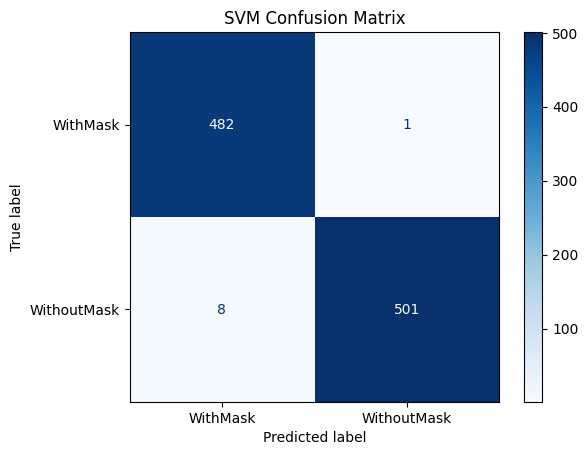

In [ ]:
y_pred_svm = svm.predict(X_test)
cm = confusion_matrix(np.argmax(y_test_enc, axis=1), y_pred_svm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("SVM Confusion Matrix")
plt.show()

# **Classification Report**
#### Memberikan metrik klasifikasi:
*   `Precision`: Akurasi prediksi positif.
*   `Recall`: Seberapa baik model mendeteksi semua positif.
*   `F1-score`: Rata-rata harmonik precision dan recall.



In [ ]:
print("Classification Report:")
print(classification_report(np.argmax(y_test_enc, axis=1), y_pred_svm, target_names=le.classes_))

Classification Report:
              precision    recall  f1-score   support

    WithMask       0.98      1.00      0.99       483
 WithoutMask       1.00      0.98      0.99       509

    accuracy                           0.99       992
   macro avg       0.99      0.99      0.99       992
weighted avg       0.99      0.99      0.99       992



# **Visualisasi Prediksi Acak**
#### Digunakan untuk menampilkan beberapa gambar acak dari` test set`. Prediksi ditampilkan dan dibandingkan dengan `label` asli. Judul warna `hijau` untuk prediksi **benar**, `merah` jika **salah** hal ini dilakukan untuk memudahkan identifikasi kesalahan model secara visual.

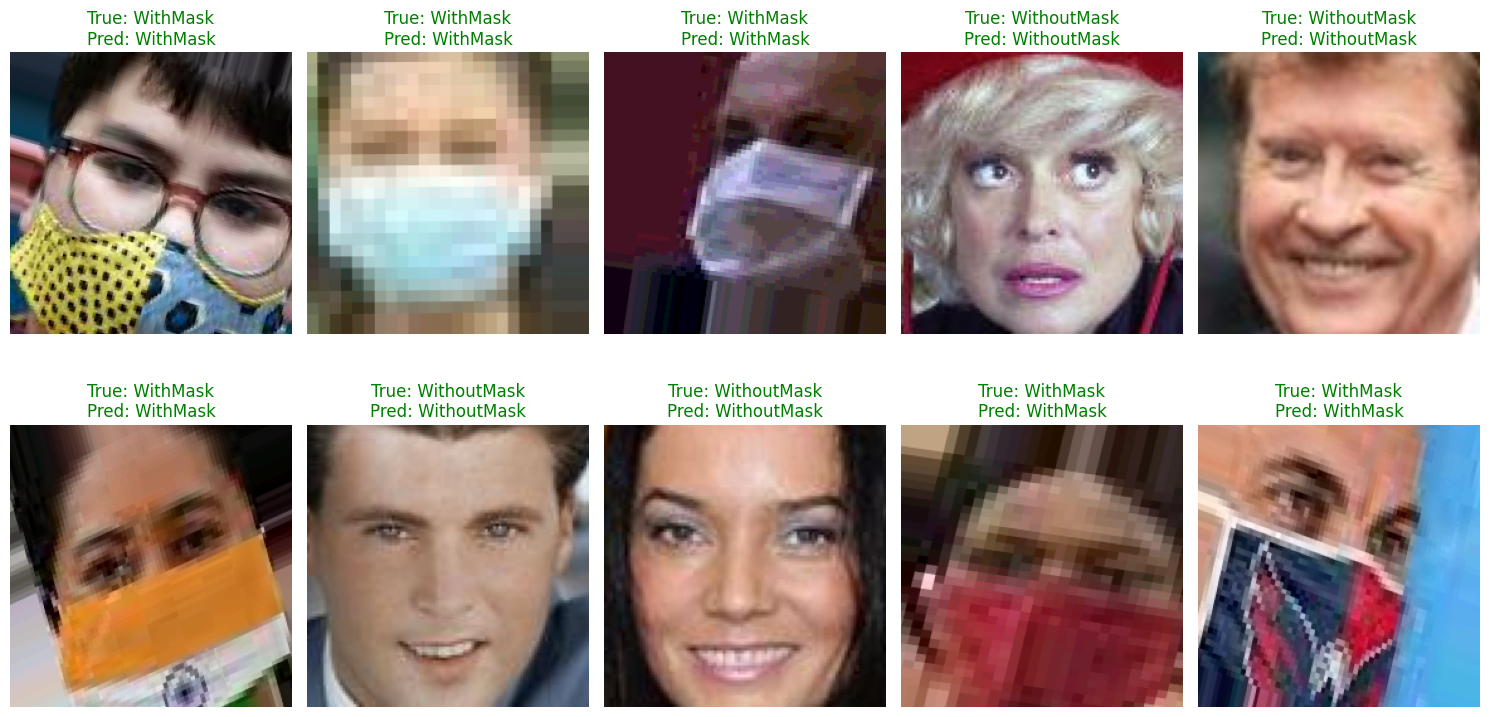

In [ ]:
def visualize_sample_predictions(model, folder_path, label_encoder, scaler, num_samples=10):
    image_paths = []
    labels = []

    for class_name in os.listdir(folder_path):
        class_folder = os.path.join(folder_path, class_name)
        for img_file in os.listdir(class_folder):
            image_paths.append(os.path.join(class_folder, img_file))
            labels.append(class_name)

    indices = np.random.choice(len(image_paths), num_samples, replace=False)

    plt.figure(figsize=(15, 8))
    for i, idx in enumerate(indices):
        img_path = image_paths[idx]
        true_label = labels[idx]
        image = cv2.imread(img_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        feature = extract_hog_features(image)
        feature = scaler.transform([feature])
        pred = model.predict(feature)[0]
        pred_label = label_encoder.inverse_transform([pred])[0]

        plt.subplot(2, 5, i+1)
        plt.imshow(image_rgb)
        plt.title(f"True: {true_label}\nPred: {pred_label}",
                  color='green' if true_label == pred_label else 'red')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_sample_predictions(svm, test_img_path, le, scaler, num_samples=10)